<a href="https://colab.research.google.com/github/Annie-Yeeun-Jang/Yeeun-J/blob/master/BERT_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import pandas as pd
from google.colab import drive
drive.mount('./gdrive', force_remount=True)

Mounted at ./gdrive


# Data Preparation


In [19]:
#source_folder = '/content/drive/My Drive/transformers/Data'
destination_folder = '/content/gdrive/My Drive/transformers/Model'
source_folder = '/content/gdrive/Shareddrives/text_conf/dataset/preprocessed/yelc'

In [20]:
#/content/gdrive/Shareddrives/text_conf/dataset/preprocessed/yelc/YELC_preprocessed_A.txt

In [21]:
with open('/content/gdrive/Shareddrives/text_conf/dataset/preprocessed/yelc/YELC_preprocessed_A.txt', encoding = 'UTF-8', newline = '\n',errors='ignore') as f:
  nonn = f.readlines()

In [22]:
with open('/content/gdrive/Shareddrives/text_conf/dataset/preprocessed/yelc/YELC_preprocessed_C.txt', encoding = 'UTF-8', newline = '\n',errors='ignore') as f:
  nat = f.readlines()

In [ ]:
nonn

In [ ]:
nat

In [25]:
nonn_df = pd.DataFrame({'text':nonn, 'label': 0})
native_df = pd.DataFrame({'text':nat, 'label': 1})

In [26]:
all_df = pd.concat([nonn_df,native_df], axis = 0)

In [27]:
all_df

,text,label
0,My favorite teacher's name is Jae-Won Jung my ...,0
1,She often tell us interesting story. \n,0
2,So she's lesson was not bored. \n,0
3,I don't think that all Korean men should be fo...,0
4,my best friend name is satbyul. \n,0
...,...,...
952,This is a very effective method because studen...,1
953,"In conclusion, physical punishment should be a...",1
954,Schools and teachers should always have the st...,1
955,"Then, physical punishment would not be linked ...",1


In [28]:
shuff_df = all_df.sample(frac=1).reset_index(drop=True) 

In [ ]:
shuff_df

In [30]:
train_df = shuff_df[:int(len(shuff_df)*0.6)].reset_index(drop=True) 
val_df = shuff_df[int(len(shuff_df)*0.6):int(len(shuff_df)*0.7)].reset_index(drop=True)
test_df = shuff_df[int(len(shuff_df)*0.7):].reset_index(drop=True)

In [33]:
train_df.to_csv('/content/gdrive/Shareddrives/text_conf/dataset/preprocessed/yelc/yelc_train.csv')
val_df.to_csv('/content/gdrive/Shareddrives/text_conf/dataset/preprocessed/yelc/yelc_val.csv')
test_df.to_csv('/content/gdrive/Shareddrives/text_conf/dataset/preprocessed/yelc/yelc_test.csv')

# Libraries

In [17]:
!pip install transformers

     |████████████████████████████████| 2.5MB 7.9MB/s 
     |████████████████████████████████| 3.3MB 44.6MB/s 
     |████████████████████████████████| 901kB 45.9MB/s 


In [18]:
!pip install -U torchtext==0.8.0

     |████████████████████████████████| 7.0MB 7.0MB/s 
  Found existing installation: torchtext 0.10.0
    Uninstalling torchtext-0.10.0:
      Successfully uninstalled torchtext-0.10.0


# Model

In [4]:
!pip install torchtext

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(device)


cpu


# Preliminaries

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [11]:
destination_folder = '/content/gdrive/MyDrive/transformer-ckpt'
data_folder = '/content/gdrive/Shareddrives/text_conf/dataset/preprocessed/yelc/'

In [21]:
print(vars(train[0]))

{'label': '0', 'text': [101, 1045, 5993, 2008, 2111, 2442, 2224, 2037, 2613, 2171, 2006, 1996, 4274, 1012, 102]}


In [ ]:
for l, d in train_iter:
  print("data: ",d) # 이건 뭐에 해당하는거지...?
  print("label: ", l)
  print("*"*30)

In [30]:
# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

#label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode,is_target = True, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
#fields = [('label', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]
fields = [('label', label_field), ('text', text_field)] #fields = df columns

# TabularDataset
train, valid, test = TabularDataset.splits(path=data_folder, train='yelc_train.csv',validation= 'yelc_val.csv', test='yelc_test.csv', format='CSV', fields=fields, skip_header=True)

# Iterators
train_iter = BucketIterator(train, batch_size=16, device=device, shuffle=True)
valid_iter = BucketIterator(valid, batch_size=16, device=device, shuffle=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)
#train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text), device=device, train=True, sort=True, sort_within_batch=True)
#valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.text), device=device, train=True, sort=True, sort_within_batch=True)
#test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warn

In [40]:
next(iter(train_iter)).label #라벨 왜이럼??????

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


tensor([ 7490.,  8205.,    81., 10785.,  4258., 10346.,  5334.,  6211., 10002.,
         2832., 11920.,  4417.,  9546.,  6564.,  8145.,  8474.])

In [ ]:
print(text_field.vocab.stoi)

# Models

In [34]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

# Training

In [39]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [38]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, text) in train_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            text = text.type(torch.LongTensor)  
            text = text.to(device)
            print("labels shape:{} , text shape: {}".format(labels, text))
            output = model(text, labels)
            print("output shape: ", output.shape)

            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (labels, text) in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        text = text.type(torch.LongTensor)  
                        text = text.to(device)
                        output = model(text, labels)
                        
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [39]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

labels shape:tensor([ 5545,  7839,  9650,  6435, 10140,  2914,  1493,  8512,  7285,  2584,
        12302,  1300,  3473, 10588, 10465,  3661]) , text shape: tensor([[ 101, 2017, 2031,  ...,    0,    0,    0],
        [ 101, 2096, 1045,  ...,    0,    0,    0],
        [ 101, 2036, 2493,  ...,    0,    0,    0],
        ...,
        [ 101, 2065, 2162,  ...,    0,    0,    0],
        [ 101, 3558, 7750,  ...,    0,    0,    0],
        [ 101, 2061, 1045,  ...,    0,    0,    0]])


IndexError: ignored

In [40]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

FileNotFoundError: ignored

# Evaluation

In [ ]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, text) in test_loader:

                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(text, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

Model loaded from <== /content/drive/My Drive/transformers/Model/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.9804    0.9585    0.9693       313
           0     0.9600    0.9811    0.9705       318

    accuracy                         0.9699       631
   macro avg     0.9702    0.9698    0.9699       631
weighted avg     0.9701    0.9699    0.9699       631



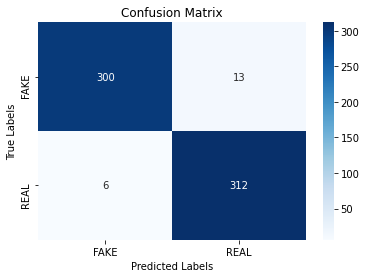

In [ ]:
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)